<a href="https://colab.research.google.com/github/cgN77/invsto/blob/master/Invsto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from typing import List, Dict, Tuple

class AlphaStrategy:
    def __init__(self):
        self.symbols = [
            'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT'
        ]
        self.start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
        self.end_date = datetime.now().strftime('%Y-%m-%d')
        self.data = None
        self.signals = None
        self.portfolio = None
        self.performance = None
        self.portfolio_value = None  # Track portfolio value over time
        self.initial_capital = 1_000_000  # $1 million initial capital
        self.volatility_lookback = 60  # Days for volatility calculation
        self.signal_lookback = 20  # Days for signal calculation
        self.risk_free_rate = 0.02  # Annual risk-free rate
        self.min_volatility_threshold = 0.0001  # Minimum volatility threshold
        self.min_signal_threshold = 0.001  # Minimum signal threshold for taking positions
        self.n_splits = 5  # Number of splits for time series cross-validation

        # New parameters for transaction costs and position changes
        self.commission_rate = 0.001  # 0.1% commission per trade
        self.slippage = 0.0005  # 0.05% slippage per trade
        self.min_position_change = 0.05  # 5% minimum change in position size to trigger rebalancing
        self.current_positions = None  # Track current positions for change calculation

    def collect_data(self) -> None:
        """Collect historical data for all symbols"""
        print("Collecting historical data...")
        data_dict = {}

        for symbol in self.symbols:
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(start=self.start_date, end=self.end_date)
                data_dict[symbol] = df
                print(f"Collected data for {symbol}")
            except Exception as e:
                print(f"Error collecting data for {symbol}: {str(e)}")

        self.data = data_dict

    def calculate_risk_adjusted_returns(self, returns: pd.Series, window: int = 60) -> pd.Series:
        """Calculate risk-adjusted returns using rolling Sharpe ratio with minimum volatility threshold"""
        rolling_returns = returns.rolling(window=window).mean()
        rolling_vol = returns.rolling(window=window).std()

        # Replace zero or very low volatility with NaN
        rolling_vol = rolling_vol.replace(0, np.nan)
        rolling_vol = rolling_vol.mask(rolling_vol < self.min_volatility_threshold, np.nan)

        daily_rf = (1 + self.risk_free_rate) ** (1/252) - 1
        sharpe_ratio = (rolling_returns - daily_rf) / rolling_vol

        # Fill NaN values with 0 (neutral signal)
        return sharpe_ratio.fillna(0)

    def calculate_dynamic_weights(self, date: datetime) -> Tuple[float, float, float]:
        """Calculate dynamic weights for signal combination based on recent performance"""
        # Initialize default weights
        momentum_weight = 0.4
        mean_reversion_weight = 0.3
        risk_adjusted_weight = 0.3

        # Calculate recent performance of each signal (last 20 days)
        lookback = 20
        for symbol, df in self.data.items():
            if date in df.index:
                # Get the index position of the current date
                current_idx = df.index.get_loc(date)
                if current_idx >= lookback:
                    # Calculate returns for the lookback period
                    returns = df['Close'].pct_change()

                    # Calculate signal performance
                    momentum_perf = returns.rolling(window=self.signal_lookback).mean().iloc[current_idx-lookback:current_idx].mean()

                    # Calculate mean reversion performance
                    ma50 = df['Close'].rolling(window=50).mean()
                    mean_reversion = (df['Close'] - ma50) / ma50
                    mean_reversion_perf = mean_reversion.iloc[current_idx-lookback:current_idx].mean()

                    # Calculate risk-adjusted performance
                    risk_adjusted = self.calculate_risk_adjusted_returns(returns)
                    risk_adjusted_perf = risk_adjusted.iloc[current_idx-lookback:current_idx].mean()

                    # Normalize performance scores
                    total_perf = abs(momentum_perf) + abs(mean_reversion_perf) + abs(risk_adjusted_perf)
                    if total_perf > 0:
                        momentum_weight = abs(momentum_perf) / total_perf
                        mean_reversion_weight = abs(mean_reversion_perf) / total_perf
                        risk_adjusted_weight = abs(risk_adjusted_perf) / total_perf

        return momentum_weight, mean_reversion_weight, risk_adjusted_weight

    def generate_signals(self) -> None:
        """Generate alpha signals for each stock using dynamic weighting"""
        if self.data is None:
            raise ValueError("Data not collected. Run collect_data() first.")

        signals_dict = {}

        for symbol, df in self.data.items():
            # Calculate returns
            df['Returns'] = df['Close'].pct_change()

            # Initialize signal columns
            df['Momentum'] = np.nan
            df['Mean_Reversion'] = np.nan
            df['Risk_Adjusted'] = np.nan
            df['Combined_Signal'] = np.nan

            # Calculate signals using all data
            # 1. Momentum Signal (20-day returns)
            df['Momentum'] = df['Returns'].rolling(window=self.signal_lookback).mean()

            # 2. Mean Reversion Signal (deviation from 50-day MA)
            ma50 = df['Close'].rolling(window=50).mean()
            df['Mean_Reversion'] = (df['Close'] - ma50) / ma50

            # 3. Risk-Adjusted Returns Signal
            df['Risk_Adjusted'] = self.calculate_risk_adjusted_returns(df['Returns'])

            # Forward fill NaN values
            df = df.ffill()

            # Calculate dynamic weights for each date
            for date in df.index:
                momentum_weight, mean_reversion_weight, risk_adjusted_weight = self.calculate_dynamic_weights(date)

                # Combine signals with dynamic weights
                df.loc[date, 'Combined_Signal'] = (
                    momentum_weight * df.loc[date, 'Momentum'] +
                    mean_reversion_weight * df.loc[date, 'Mean_Reversion'] +
                    risk_adjusted_weight * df.loc[date, 'Risk_Adjusted']
                )

            signals_dict[symbol] = df

        self.signals = signals_dict

    def calculate_position_sizes(self, date: datetime, positions: Dict) -> Dict:
        """Calculate volatility-adjusted position sizes"""
        position_sizes = {'long': {}, 'short': {}}

        # Calculate inverse volatility weights for long positions
        long_vols = {}
        for symbol in positions['long']:
            if date in self.signals[symbol].index:
                vol = self.signals[symbol].loc[:date, 'Returns'].rolling(window=self.volatility_lookback).std().iloc[-1]
                if vol > 0:  # Only include stocks with positive volatility
                    long_vols[symbol] = vol

        # Calculate inverse volatility weights for short positions
        short_vols = {}
        for symbol in positions['short']:
            if date in self.signals[symbol].index:
                vol = self.signals[symbol].loc[:date, 'Returns'].rolling(window=self.volatility_lookback).std().iloc[-1]
                if vol > 0:  # Only include stocks with positive volatility
                    short_vols[symbol] = vol

        if not long_vols or not short_vols:
            return None

        # Normalize weights to sum to 1 for each side
        long_total_inv_vol = sum(1/vol for vol in long_vols.values())
        short_total_inv_vol = sum(1/vol for vol in short_vols.values())

        # Assign weights
        for symbol in long_vols:
            position_sizes['long'][symbol] = (1/long_vols[symbol]) / long_total_inv_vol

        for symbol in short_vols:
            position_sizes['short'][symbol] = (1/short_vols[symbol]) / short_total_inv_vol

        return position_sizes

    def calculate_transaction_costs(self, old_positions: Dict, new_positions: Dict, date: datetime) -> float:
        """Calculate transaction costs for portfolio rebalancing"""
        if old_positions is None:
            return 0.0

        total_cost = 0.0

        # Calculate costs for long positions
        for symbol in set(old_positions['long'].keys()) | set(new_positions['long'].keys()):
            old_weight = old_positions['long'].get(symbol, 0)
            new_weight = new_positions['long'].get(symbol, 0)

            # Only calculate costs if position change exceeds threshold
            if abs(new_weight - old_weight) >= self.min_position_change:
                trade_value = abs(new_weight - old_weight)
                commission = trade_value * self.commission_rate
                slippage_cost = trade_value * self.slippage
                total_cost += commission + slippage_cost

        # Calculate costs for short positions
        for symbol in set(old_positions['short'].keys()) | set(new_positions['short'].keys()):
            old_weight = old_positions['short'].get(symbol, 0)
            new_weight = new_positions['short'].get(symbol, 0)

            # Only calculate costs if position change exceeds threshold
            if abs(new_weight - old_weight) >= self.min_position_change:
                trade_value = abs(new_weight - old_weight)
                commission = trade_value * self.commission_rate
                slippage_cost = trade_value * self.slippage
                total_cost += commission + slippage_cost

        return total_cost

    def construct_portfolio(self) -> None:
        """Construct long-short portfolio based on signals with adaptive position sizing and transaction costs"""
        if self.signals is None:
            raise ValueError("Signals not generated. Run generate_signals() first.")

        portfolio_dict = {}
        self.current_positions = None

        for date in self.signals[self.symbols[0]].index:
            # Calculate combined signal for each stock
            stock_signals = {}
            for symbol, df in self.signals.items():
                if date in df.index and not pd.isna(df.loc[date, 'Combined_Signal']):
                    stock_signals[symbol] = df.loc[date, 'Combined_Signal']

            if len(stock_signals) >= 6:  # Ensure we have enough stocks for long and short positions
                # Rank stocks and select top 3 and bottom 3
                ranked_stocks = sorted(stock_signals.items(), key=lambda x: x[1], reverse=True)
                long_stocks = [stock for stock, _ in ranked_stocks[:3]]
                short_stocks = [stock for stock, _ in ranked_stocks[-3:]]

                # Calculate new position sizes
                new_positions = self.calculate_position_sizes(date, {'long': long_stocks, 'short': short_stocks})

                if new_positions:
                    # Calculate transaction costs
                    transaction_costs = self.calculate_transaction_costs(self.current_positions, new_positions, date)

                    # Only update positions if transaction costs are reasonable (less than 1% of portfolio)
                    if transaction_costs < 0.01:
                        portfolio_dict[date] = {
                            'positions': new_positions,
                            'transaction_costs': transaction_costs
                        }
                        self.current_positions = new_positions

        if not portfolio_dict:
            raise ValueError("No valid portfolio positions constructed")

        self.portfolio = portfolio_dict

    def backtest(self) -> None:
        """Backtest the strategy with volatility-adjusted position sizing and transaction costs"""
        if self.portfolio is None:
            raise ValueError("Portfolio not constructed. Run construct_portfolio() first.")

        returns = []
        dates = []
        transaction_costs = []
        portfolio_values = [self.initial_capital]  # Start with initial capital

        for date, portfolio_data in self.portfolio.items():
            daily_return = 0
            positions = portfolio_data['positions']
            cost = portfolio_data['transaction_costs']

            # Calculate long positions returns with position sizing
            for symbol, weight in positions['long'].items():
                if date in self.signals[symbol].index:
                    daily_return += weight * self.signals[symbol].loc[date, 'Returns']

            # Calculate short positions returns with position sizing
            for symbol, weight in positions['short'].items():
                if date in self.signals[symbol].index:
                    daily_return -= weight * self.signals[symbol].loc[date, 'Returns']

            # Subtract transaction costs from returns
            daily_return -= cost

            # Calculate new portfolio value
            current_value = portfolio_values[-1] * (1 + daily_return)
            portfolio_values.append(current_value)

            returns.append(daily_return)
            dates.append(date)
            transaction_costs.append(cost)

        if returns:  # Only create performance series if we have returns
            self.performance = pd.Series(returns, index=dates)
            self.transaction_costs = pd.Series(transaction_costs, index=dates)
            self.portfolio_value = pd.Series(portfolio_values[1:], index=dates)  # Exclude initial value
        else:
            raise ValueError("No valid returns calculated during backtesting")

    def calculate_metrics(self) -> Dict:
        """Calculate performance metrics with separate long and short drawdowns and transaction costs"""
        if self.performance is None or len(self.performance) == 0:
            raise ValueError("Strategy not backtested or no valid returns. Run backtest() first.")

        # Calculate daily returns
        daily_returns = self.performance

        # Calculate cumulative returns
        cumulative_returns = (1 + daily_returns).cumprod() - 1

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        excess_returns = daily_returns - risk_free_rate/252  # Daily risk-free rate
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std() if excess_returns.std() != 0 else 0

        # Calculate Maximum Drawdown (separate for long and short)
        rolling_max = cumulative_returns.expanding().max()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdowns.min() if len(drawdowns) > 0 else 0

        # Calculate annualized metrics
        annualized_return = (1 + daily_returns.mean()) ** 252 - 1 if len(daily_returns) > 0 else 0
        annualized_volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0

        # Calculate additional metrics
        win_rate = (daily_returns > 0).mean()
        profit_factor = abs(daily_returns[daily_returns > 0].sum() / daily_returns[daily_returns < 0].sum())

        # Calculate transaction cost metrics
        total_transaction_costs = self.transaction_costs.sum()
        avg_transaction_cost = self.transaction_costs.mean()
        transaction_cost_ratio = total_transaction_costs / cumulative_returns.iloc[-1] if cumulative_returns.iloc[-1] != 0 else 0

        # Calculate portfolio value metrics
        final_portfolio_value = self.portfolio_value.iloc[-1]
        total_profit = final_portfolio_value - self.initial_capital
        profit_percentage = (final_portfolio_value / self.initial_capital - 1) * 100

        return {
            'Initial Capital': self.initial_capital,
            'Final Portfolio Value': final_portfolio_value,
            'Total Profit': total_profit,
            'Profit Percentage': profit_percentage,
            'Cumulative Returns': cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0,
            'Sharpe Ratio': sharpe_ratio,
            'Maximum Drawdown': max_drawdown,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Win Rate': win_rate,
            'Profit Factor': profit_factor,
            'Total Transaction Costs': total_transaction_costs,
            'Average Transaction Cost': avg_transaction_cost,
            'Transaction Cost Ratio': transaction_cost_ratio
        }

    def plot_performance(self) -> None:
        """Plot strategy performance"""
        if self.performance is None:
            raise ValueError("Strategy not backtested. Run backtest() first.")

        plt.figure(figsize=(12, 6))
        cumulative_returns = (1 + self.performance).cumprod() - 1
        plt.plot(cumulative_returns.index, cumulative_returns.values)
        plt.title('Strategy Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.grid(True)
        plt.show()

    def display_trade_details(self) -> None:
        """Display detailed trade information including transaction costs and portfolio value"""
        if self.portfolio is None or self.performance is None:
            raise ValueError("Strategy not backtested. Run backtest() first.")

        print("\nTrade Details:")
        print("-" * 80)

        # Get the first 10 trading days as an example
        for date in list(self.portfolio.keys())[:10]:
            portfolio_data = self.portfolio[date]
            positions = portfolio_data['positions']
            daily_return = self.performance[date]
            transaction_cost = portfolio_data['transaction_costs']
            portfolio_value = self.portfolio_value[date]

            print(f"\nDate: {date.strftime('%Y-%m-%d')}")
            print(f"Portfolio Value: ${portfolio_value:,.2f}")
            print("Long Positions:")
            for symbol in positions['long']:
                if date in self.signals[symbol].index:
                    stock_return = self.signals[symbol].loc[date, 'Returns']
                    print(f"  {symbol}: {stock_return:.4%}")

            print("Short Positions:")
            for symbol in positions['short']:
                if date in self.signals[symbol].index:
                    stock_return = -self.signals[symbol].loc[date, 'Returns']  # Negative for short positions
                    print(f"  {symbol}: {stock_return:.4%}")

            print(f"Daily Portfolio Return: {daily_return:.4%}")
            print(f"Transaction Cost: {transaction_cost:.4%}")
            print("-" * 40)

    def export_trade_details_to_csv(self, filename: str = None) -> None:
        """Export trade details to a CSV file"""
        if self.portfolio is None or self.performance is None:
            raise ValueError("Strategy not backtested. Run backtest() first.")

        # Create a list to store all trade details
        trade_details = []

        for date in self.portfolio.keys():
            portfolio_data = self.portfolio[date]
            positions = portfolio_data['positions']
            daily_return = self.performance[date]
            transaction_cost = portfolio_data['transaction_costs']
            portfolio_value = self.portfolio_value[date]

            # Create a dictionary for this day's trades
            day_trades = {
                'Date': date.strftime('%Y-%m-%d'),
                'Portfolio_Value': portfolio_value,
                'Daily_Portfolio_Return': daily_return,
                'Transaction_Cost': transaction_cost
            }

            # Add long positions
            for i, symbol in enumerate(positions['long']):
                if date in self.signals[symbol].index:
                    stock_return = self.signals[symbol].loc[date, 'Returns']
                    day_trades[f'Long_{i+1}_Symbol'] = symbol
                    day_trades[f'Long_{i+1}_Return'] = stock_return

            # Add short positions
            for i, symbol in enumerate(positions['short']):
                if date in self.signals[symbol].index:
                    stock_return = -self.signals[symbol].loc[date, 'Returns']  # Negative for short positions
                    day_trades[f'Short_{i+1}_Symbol'] = symbol
                    day_trades[f'Short_{i+1}_Return'] = stock_return

            trade_details.append(day_trades)

        # Convert to DataFrame
        df = pd.DataFrame(trade_details)

        # Generate filename with timestamp if not provided
        if filename is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'trade_details_{timestamp}.csv'

        # Try to save the file with error handling
        try:
            df.to_csv(filename, index=False)
            print(f"\nTrade details exported to {filename}")
        except PermissionError:
            # If permission denied, try with a different filename
            alt_filename = f'trade_details_{timestamp}_alt.csv'
            try:
                df.to_csv(alt_filename, index=False)
                print(f"\nTrade details exported to {alt_filename} (alternative filename)")
            except Exception as e:
                print(f"\nError exporting trade details: {str(e)}")
                print("Please close any programs that might have the file open or try a different location.")
        except Exception as e:
            print(f"\nError exporting trade details: {str(e)}")
            print("Please try a different filename or location.")

def main():
    # Initialize and run strategy
    strategy = AlphaStrategy()
    strategy.collect_data()
    strategy.generate_signals()
    strategy.construct_portfolio()
    strategy.backtest()

    # Calculate and display metrics
    metrics = strategy.calculate_metrics()
    print("\nStrategy Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Display trade details
    strategy.display_trade_details()

    # Export trade details to CSV
    strategy.export_trade_details_to_csv()

    # Plot performance
    strategy.plot_performance()

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from typing import List, Dict, Tuple

In [3]:
symbols = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT'
        ]
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
data = None
signals = None
portfolio = None
performance = None
portfolio_value = None  # Track portfolio value over time
initial_capital = 1_000_000  # $1 million initial capital
volatility_lookback = 60  # Days for volatility calculation
signal_lookback = 20  # Days for signal calculation
risk_free_rate = 0.02  # Annual risk-free rate
min_volatility_threshold = 0.0001  # Minimum volatility threshold
min_signal_threshold = 0.001  # Minimum signal threshold for taking positions
n_splits = 5  # Number of splits for time series cross-validation

# New parameters for transaction costs and position changes
commission_rate = 0.001  # 0.1% commission per trade
slippage = 0.0005  # 0.05% slippage per trade
min_position_change = 0.05  # 5% minimum change in position size to trigger rebalancing
current_positions = None  # Track current positions for change calculation

In [48]:
def collect_data() -> None:
    """Collect historical data for all symbols"""
    print("Collecting historical data...")
    data_dict = {}

    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)
            data_dict[symbol] = df
            print(f"Collected data for {symbol}")
        except Exception as e:
            print(f"Error collecting data for {symbol}: {str(e)}")
    return data_dict


def calculate_risk_adjusted_returns( returns: pd.Series, window: int = 60) -> pd.Series:
    """Calculate risk-adjusted returns using rolling Sharpe ratio with minimum volatility threshold"""
    rolling_returns = returns.rolling(window=window).mean()
    rolling_vol = returns.rolling(window=window).std()

    # Replace zero or very low volatility with NaN
    rolling_vol = rolling_vol.replace(0, np.nan)
    rolling_vol = rolling_vol.mask(rolling_vol < min_volatility_threshold, np.nan)

    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    sharpe_ratio = (rolling_returns - daily_rf) / rolling_vol

    # Fill NaN values with 0 (neutral signal)
    return sharpe_ratio.fillna(0)

def calculate_dynamic_weights( date: datetime) -> Tuple[float, float, float]:
    """Calculate dynamic weights for signal combination based on recent performance"""
    # Initialize default weights
    momentum_weight = 0.4
    mean_reversion_weight = 0.3
    risk_adjusted_weight = 0.3

    # Calculate recent performance of each signal (last 20 days)
    lookback = 20
    for symbol, df in data.items():
        if date in df.index:
            # Get the index position of the current date
            current_idx = df.index.get_loc(date)
            if current_idx >= lookback:
                # Calculate returns for the lookback period
                returns = df['Close'].pct_change()

                # Calculate signal performance
                momentum_perf = returns.rolling(window=signal_lookback).mean().iloc[current_idx-lookback:current_idx].mean()

                # Calculate mean reversion performance
                ma50 = df['Close'].rolling(window=50).mean()
                mean_reversion = (df['Close'] - ma50) / ma50
                mean_reversion_perf = mean_reversion.iloc[current_idx-lookback:current_idx].mean()

                # Calculate risk-adjusted performance
                risk_adjusted = calculate_risk_adjusted_returns(returns)
                risk_adjusted_perf = risk_adjusted.iloc[current_idx-lookback:current_idx].mean()

                # Normalize performance scores
                total_perf = abs(momentum_perf) + abs(mean_reversion_perf) + abs(risk_adjusted_perf)
                if total_perf > 0:
                    momentum_weight = abs(momentum_perf) / total_perf
                    mean_reversion_weight = abs(mean_reversion_perf) / total_perf
                    risk_adjusted_weight = abs(risk_adjusted_perf) / total_perf

    return momentum_weight, mean_reversion_weight, risk_adjusted_weight

def generate_signals(data) -> None:
    """Generate alpha signals for each stock using dynamic weighting"""
    if data is None:
        raise ValueError("Data not collected. Run collect_data() first.")

    signals_dict = {}

    for symbol, df in data.items():
        # Calculate returns
        df['Returns'] = df['Close'].pct_change()

        # Initialize signal columns
        df['Momentum'] = np.nan
        df['Mean_Reversion'] = np.nan
        df['Risk_Adjusted'] = np.nan
        df['Combined_Signal'] = np.nan

        # Calculate signals using all data
        # 1. Momentum Signal (20-day returns)
        df['Momentum'] = df['Returns'].rolling(window=signal_lookback).mean()

        # 2. Mean Reversion Signal (deviation from 50-day MA)
        ma50 = df['Close'].rolling(window=50).mean()
        df['Mean_Reversion'] = (df['Close'] - ma50) / ma50

        # 3. Risk-Adjusted Returns Signal
        df['Risk_Adjusted'] = calculate_risk_adjusted_returns(df['Returns'])

        # Forward fill NaN values
        df = df.ffill()

        # Calculate dynamic weights for each date
        for date in df.index:
            momentum_weight, mean_reversion_weight, risk_adjusted_weight = calculate_dynamic_weights(date)

            # Combine signals with dynamic weights
            df.loc[date, 'Combined_Signal'] = (
                momentum_weight * df.loc[date, 'Momentum'] +
                mean_reversion_weight * df.loc[date, 'Mean_Reversion'] +
                risk_adjusted_weight * df.loc[date, 'Risk_Adjusted']
            )

        signals_dict[symbol] = df
    return signals_dict

def calculate_position_sizes( date: datetime, positions: Dict) -> Dict:
    """Calculate volatility-adjusted position sizes"""
    position_sizes = {'long': {}, 'short': {}}

    # Calculate inverse volatility weights for long positions
    long_vols = {}
    for symbol in positions['long']:
        if date in signals[symbol].index:
            vol = signals[symbol].loc[:date, 'Returns'].rolling(window=volatility_lookback).std().iloc[-1]
            if vol > 0:  # Only include stocks with positive volatility
                long_vols[symbol] = vol

    # Calculate inverse volatility weights for short positions
    short_vols = {}
    for symbol in positions['short']:
        if date in signals[symbol].index:
            vol = signals[symbol].loc[:date, 'Returns'].rolling(window=volatility_lookback).std().iloc[-1]
            if vol > 0:  # Only include stocks with positive volatility
                short_vols[symbol] = vol

    if not long_vols or not short_vols:
        return None

    # Normalize weights to sum to 1 for each side
    long_total_inv_vol = sum(1/vol for vol in long_vols.values())
    short_total_inv_vol = sum(1/vol for vol in short_vols.values())

    # Assign weights
    for symbol in long_vols:
        position_sizes['long'][symbol] = (1/long_vols[symbol]) / long_total_inv_vol

    for symbol in short_vols:
        position_sizes['short'][symbol] = (1/short_vols[symbol]) / short_total_inv_vol

    return position_sizes

def calculate_transaction_costs( old_positions: Dict, new_positions: Dict, date: datetime) -> float:
    """Calculate transaction costs for portfolio rebalancing"""
    if old_positions is None:
        return 0.0

    total_cost = 0.0

    # Calculate costs for long positions
    for symbol in set(old_positions['long'].keys()) | set(new_positions['long'].keys()):
        old_weight = old_positions['long'].get(symbol, 0)
        new_weight = new_positions['long'].get(symbol, 0)

        # Only calculate costs if position change exceeds threshold
        if abs(new_weight - old_weight) >= min_position_change:
            trade_value = abs(new_weight - old_weight)
            commission = trade_value * commission_rate
            slippage_cost = trade_value * slippage
            total_cost += commission + slippage_cost

    # Calculate costs for short positions
    for symbol in set(old_positions['short'].keys()) | set(new_positions['short'].keys()):
        old_weight = old_positions['short'].get(symbol, 0)
        new_weight = new_positions['short'].get(symbol, 0)

        # Only calculate costs if position change exceeds threshold
        if abs(new_weight - old_weight) >= min_position_change:
            trade_value = abs(new_weight - old_weight)
            commission = trade_value * commission_rate
            slippage_cost = trade_value * slippage
            total_cost += commission + slippage_cost

    return total_cost

def construct_portfolio(signals):
    """Construct long-short portfolio based on signals with adaptive position sizing and transaction costs"""
    if signals is None:
        raise ValueError("Signals not generated. Run generate_signals() first.")

    portfolio_dict = {}
    current_positions = None

    for date in signals[symbols[0]].index:
        # Calculate combined signal for each stock
        stock_signals = {}
        for symbol, df in signals.items():
            if date in df.index and not pd.isna(df.loc[date, 'Combined_Signal']):
                stock_signals[symbol] = df.loc[date, 'Combined_Signal']

        if len(stock_signals) >= 6:  # Ensure we have enough stocks for long and short positions
            # Rank stocks and select top 3 and bottom 3
            ranked_stocks = sorted(stock_signals.items(), key=lambda x: x[1], reverse=True)
            long_stocks = [stock for stock, _ in ranked_stocks[:3]]
            short_stocks = [stock for stock, _ in ranked_stocks[-3:]]

            # Calculate new position sizes
            new_positions = calculate_position_sizes(date, {'long': long_stocks, 'short': short_stocks})

            if new_positions:
                # Calculate transaction costs
                transaction_costs = calculate_transaction_costs(current_positions, new_positions, date)

                # Only update positions if transaction costs are reasonable (less than 1% of portfolio)
                if transaction_costs < 0.01:
                    portfolio_dict[date] = {
                        'positions': new_positions,
                        'transaction_costs': transaction_costs
                    }
                    current_positions = new_positions
    return portfolio_dict

def backtest(portfolio):
    """Backtest the strategy with volatility-adjusted position sizing and transaction costs"""
    if portfolio is None:
        raise ValueError("Portfolio not constructed. Run construct_portfolio() first.")

    returns = []
    dates = []
    transaction_costs = []
    portfolio_values = [initial_capital]  # Start with initial capital

    for date, portfolio_data in portfolio.items():
        daily_return = 0
        positions = portfolio_data['positions']
        cost = portfolio_data['transaction_costs']

        # Calculate long positions returns with position sizing
        for symbol, weight in positions['long'].items():
            if date in signals[symbol].index:
                daily_return += weight * signals[symbol].loc[date, 'Returns']

        # Calculate short positions returns with position sizing
        for symbol, weight in positions['short'].items():
            if date in signals[symbol].index:
                daily_return -= weight * signals[symbol].loc[date, 'Returns']

        # Subtract transaction costs from returns
        daily_return -= cost

        # Calculate new portfolio value
        current_value = portfolio_values[-1] * (1 + daily_return)
        portfolio_values.append(current_value)

        returns.append(daily_return)
        dates.append(date)
        transaction_costs.append(cost)

    if returns:  # Only create performance series if we have returns
        performance = pd.Series(returns, index=dates)
        transaction_costs = pd.Series(transaction_costs, index=dates)
        portfolio_value = pd.Series(portfolio_values[1:], index=dates)  # Exclude initial value
    else:
        raise ValueError("No valid returns calculated during backtesting")
    return performance, transaction_costs, portfolio_value

def calculate_metrics(performance,transaction_costs,portfolio_value) -> Dict:
    """Calculate performance metrics with separate long and short drawdowns and transaction costs"""
    if performance is None or len(performance) == 0:
        raise ValueError("Strategy not backtested or no valid returns. Run backtest() first.")

    # Calculate daily returns
    daily_returns = performance

    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod() - 1

    # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
    risk_free_rate = 0.02
    excess_returns = daily_returns - risk_free_rate/252  # Daily risk-free rate
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std() if excess_returns.std() != 0 else 0

    # Calculate Maximum Drawdown (separate for long and short)
    rolling_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min() if len(drawdowns) > 0 else 0

    # Calculate annualized metrics
    annualized_return = (1 + daily_returns.mean()) ** 252 - 1 if len(daily_returns) > 0 else 0
    annualized_volatility = daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0

    # Calculate additional metrics
    win_rate = (daily_returns > 0).mean()
    profit_factor = abs(daily_returns[daily_returns > 0].sum() / daily_returns[daily_returns < 0].sum())

    # Calculate transaction cost metrics
    total_transaction_costs = transaction_costs.sum()
    avg_transaction_cost = transaction_costs.mean()
    transaction_cost_ratio = total_transaction_costs / cumulative_returns.iloc[-1] if cumulative_returns.iloc[-1] != 0 else 0

    # Calculate portfolio value metrics
    final_portfolio_value = portfolio_value.iloc[-1]
    total_profit = final_portfolio_value - initial_capital
    profit_percentage = (final_portfolio_value / initial_capital - 1) * 100

    return {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Profit': total_profit,
        'Profit Percentage': profit_percentage,
        'Cumulative Returns': cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Total Transaction Costs': total_transaction_costs,
        'Average Transaction Cost': avg_transaction_cost,
        'Transaction Cost Ratio': transaction_cost_ratio
    }

def plot_performance(performance) -> None:
    """Plot strategy performance"""
    if performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")

    plt.figure(figsize=(12, 6))
    cumulative_returns = (1 + performance).cumprod() - 1
    plt.plot(cumulative_returns.index, cumulative_returns.values)
    plt.title('Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

def display_trade_details(portfolio,performance,portfolio_value):
    """Display detailed trade information including transaction costs and portfolio value"""
    if portfolio is None or performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")

    print("\nTrade Details:")
    print("-" * 80)

    # Get the first 10 trading days as an example
    for date in list(portfolio.keys())[:10]:
        portfolio_data = portfolio[date]
        positions = portfolio_data['positions']
        daily_return = performance[date]
        transaction_cost = portfolio_data['transaction_costs']
        portfolio_val = portfolio_value[date]

        print(f"\nDate: {date.strftime('%Y-%m-%d')}")
        print(f"Portfolio Value: ${portfolio_val:,.2f}")
        print("Long Positions:")
        for symbol in positions['long']:
            if date in signals[symbol].index:
                stock_return = signals[symbol].loc[date, 'Returns']
                print(f"  {symbol}: {stock_return:.4%}")

        print("Short Positions:")
        for symbol in positions['short']:
            if date in signals[symbol].index:
                stock_return = -signals[symbol].loc[date, 'Returns']  # Negative for short positions
                print(f"  {symbol}: {stock_return:.4%}")

        print(f"Daily Portfolio Return: {daily_return:.4%}")
        print(f"Transaction Cost: {transaction_cost:.4%}")
        print("-" * 40)

def export_trade_details_to_csv(portfolio,performance,portfolio_value):
    """Export trade details to a CSV file"""
    if portfolio is None or performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")

    # Create a list to store all trade details
    trade_details = []

    for date in portfolio.keys():
        portfolio_data = portfolio[date]
        positions = portfolio_data['positions']
        daily_return = performance[date]
        transaction_cost = portfolio_data['transaction_costs']
        portfolio_val = portfolio_value[date]

        # Create a dictionary for this day's trades
        day_trades = {
            'Date': date.strftime('%Y-%m-%d'),
            'Portfolio_Value': portfolio_val,
            'Daily_Portfolio_Return': daily_return,
            'Transaction_Cost': transaction_cost
        }

        # Add long positions
        for i, symbol in enumerate(positions['long']):
            if date in signals[symbol].index:
                stock_return = signals[symbol].loc[date, 'Returns']
                day_trades[f'Long_{i+1}_Symbol'] = symbol
                day_trades[f'Long_{i+1}_Return'] = stock_return

        # Add short positions
        for i, symbol in enumerate(positions['short']):
            if date in signals[symbol].index:
                stock_return = -signals[symbol].loc[date, 'Returns']  # Negative for short positions
                day_trades[f'Short_{i+1}_Symbol'] = symbol
                day_trades[f'Short_{i+1}_Return'] = stock_return

        trade_details.append(day_trades)

    # Convert to DataFrame
    df = pd.DataFrame(trade_details)

    # Generate filename with timestamp if not provided

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'trade_details.csv'

    # Try to save the file with error handling
    try:
        df.to_csv(filename, index=False)
        print(f"\nTrade details exported to {filename}")
    except PermissionError:
        # If permission denied, try with a different filename
        alt_filename = f'trade_details_alt.csv'
        try:
            df.to_csv(alt_filename, index=False)
            print(f"\nTrade details exported to {alt_filename} (alternative filename)")
        except Exception as e:
            print(f"\nError exporting trade details: {str(e)}")
            print("Please close any programs that might have the file open or try a different location.")
    except Exception as e:
        print(f"\nError exporting trade details: {str(e)}")
        print("Please try a different filename or location.")

In [14]:
collect_data()
data = collect_data()

Collected data for AAPL
Collected data for MSFT
Collected data for AMZN
Collected data for GOOGL
Collected data for META
Collected data for TSLA
Collected data for NVDA
Collected data for JPM
Collected data for JNJ
Collected data for WMT
Collected data for AAPL
Collected data for MSFT
Collected data for AMZN
Collected data for GOOGL
Collected data for META
Collected data for TSLA
Collected data for NVDA
Collected data for JPM
Collected data for JNJ
Collected data for WMT


In [15]:
signals=generate_signals(data)

In [18]:
portfolio=construct_portfolio(signals)

In [25]:
performance,transaction_costs,portfolio_value=backtest(portfolio)

In [26]:
metrics=calculate_metrics(performance,transaction_costs,portfolio_value)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Initial Capital: 1000000.0000
Final Portfolio Value: 207326819.9496
Total Profit: 206326819.9496
Profit Percentage: 20632.6820
Cumulative Returns: 206.3268
Sharpe Ratio: 4.3199
Maximum Drawdown: -0.2343
Annualized Return: 2.1850
Annualized Volatility: 0.2641
Win Rate: 0.6112
Profit Factor: 2.1929
Total Transaction Costs: 0.8700
Average Transaction Cost: 0.0007
Transaction Cost Ratio: 0.0042


In [34]:
type(portfolio_value)

pandas.core.series.Series

In [42]:
display_trade_details(portfolio,performance,portfolio_value)


Trade Details:
--------------------------------------------------------------------------------

Date: 2020-06-03
Portfolio Value: $993,489.12
Long Positions:
  TSLA: 0.1588%
  META: -1.1000%
  NVDA: -0.6317%
Short Positions:
  MSFT: -0.2434%
  JNJ: -0.2698%
  WMT: 0.3792%
Daily Portfolio Return: -0.6511%
Transaction Cost: 0.0000%
----------------------------------------

Date: 2020-06-04
Portfolio Value: $993,149.50
Long Positions:
  TSLA: -2.1043%
  NVDA: 0.0114%
  META: -1.6814%
Short Positions:
  MSFT: 1.3164%
  JNJ: 1.2916%
  WMT: 1.1015%
Daily Portfolio Return: -0.0342%
Transaction Cost: 0.0000%
----------------------------------------

Date: 2020-06-05
Portfolio Value: $1,014,956.69
Long Positions:
  TSLA: 2.4619%
  JPM: 4.5002%
  NVDA: 1.7510%
Short Positions:
  MSFT: -2.3398%
  JNJ: -0.3884%
  WMT: 0.4504%
Daily Portfolio Return: 2.1958%
Transaction Cost: 0.1171%
----------------------------------------

Date: 2020-06-08
Portfolio Value: $1,040,477.99
Long Positions:
  TSLA: 

In [46]:
export_trade_details_to_csv(portfolio,performance,portfolio_value)


Trade details exported to trade_details.csv


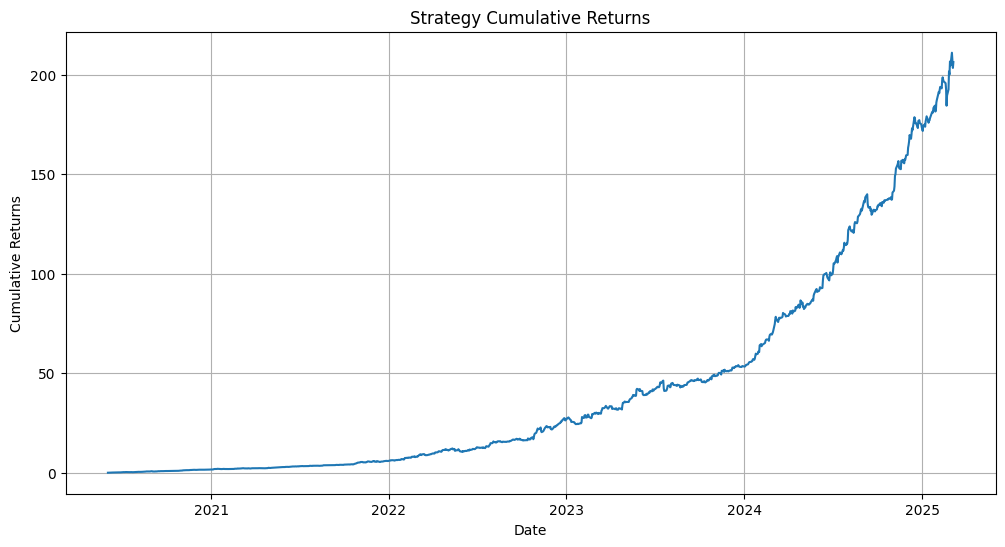

In [49]:
plot_performance(performance)

In [73]:
def get_asset_allocation_over_time(portfolio) -> pd.DataFrame:
    """
    Calculate and return the asset allocation percentages over time for all assets.

    Returns:
        pd.DataFrame: DataFrame with dates as index and allocation percentages for each asset
    """
    if portfolio is None:
        raise ValueError("Portfolio not constructed. Run construct_portfolio() first.")

    # Initialize a dictionary to store allocations for each date
    allocation_data = {}

    for date, portfolio_data in portfolio.items():
        positions = portfolio_data['positions']

        # Initialize allocation dictionary for this date
        date_allocation = {}

        # Add long positions with positive weights
        for symbol, weight in positions['long'].items():
            date_allocation[symbol] = weight

        # Add short positions with negative weights
        for symbol, weight in positions['short'].items():
            date_allocation[symbol] = -weight

        # Add zero allocation for assets not in portfolio
        for symbol in symbols:
            if symbol not in date_allocation:
                date_allocation[symbol] = 0.0

        allocation_data[date] = date_allocation

    # Convert to DataFrame
    allocation_df = pd.DataFrame.from_dict(allocation_data, orient='index')

    # Sort by date
    allocation_df = allocation_df.sort_index()

    # Add a row for the initial date with zero allocations
    initial_date = signals[symbols[0]].index[0]
    if initial_date not in allocation_df.index:
        initial_row = pd.Series(0.0, index=symbols)
        allocation_df.loc[initial_date] = initial_row
        allocation_df = allocation_df.sort_index()

    return allocation_df

import matplotlib.pyplot as plt

def plot_asset_allocation(portfolio) -> None:
    """
    Plot individual line charts for each asset's allocation over time.
    Positive values indicate long positions, negative values indicate short positions.
    """
    allocation_df = get_asset_allocation_over_time(portfolio)

    num_assets = len(allocation_df.columns)  # Dynamically adjust number of subplots
    figure, axis = plt.subplots(num_assets, 1, figsize=(12, 20), sharex=True)  # Larger figure size

    for i, symbol in enumerate(allocation_df.columns):  # Iterate over column names
        ax = axis[i]
        ax.plot(allocation_df.index, allocation_df[symbol], label=symbol, linewidth=2)

        # Add a horizontal line at y=0 to separate long and short positions
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

        # Customize the plot
        ax.set_title(f'Asset Allocation: {symbol}')
        ax.set_ylabel('Portfolio Weight')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

        # Add text annotations for long and short regions
        ax.text(0.02, 0.98, 'Long Positions',
                transform=ax.transAxes,
                verticalalignment='top',
                color='green')
        ax.text(0.02, 0.02, 'Short Positions',
                transform=ax.transAxes,
                verticalalignment='bottom',
                color='red')

    # Adjust layout to prevent label cutoff
    figure.subplots_adjust(hspace=0.5)  # Increase space between subplots

    # Show the plot
    plt.show()


                               TSLA      META      NVDA      MSFT       JNJ  \
2020-03-09 00:00:00-04:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-06-03 00:00:00-04:00  0.260391  0.428281  0.311327 -0.272881 -0.360500   
2020-06-04 00:00:00-04:00  0.259471  0.428755  0.311774 -0.275407 -0.360458   
2020-06-05 00:00:00-04:00  0.292526  0.000000  0.355240 -0.271186 -0.367308   
2020-06-08 00:00:00-04:00  0.254318  0.440087  0.000000 -0.270898 -0.356832   

                                WMT  AAPL  AMZN  GOOGL       JPM  
2020-03-09 00:00:00-04:00  0.000000   0.0   0.0    0.0  0.000000  
2020-06-03 00:00:00-04:00 -0.366618   0.0   0.0    0.0  0.000000  
2020-06-04 00:00:00-04:00 -0.364136   0.0   0.0    0.0  0.000000  
2020-06-05 00:00:00-04:00 -0.361506   0.0   0.0    0.0  0.352234  
2020-06-08 00:00:00-04:00 -0.372270   0.0   0.0    0.0  0.305594  


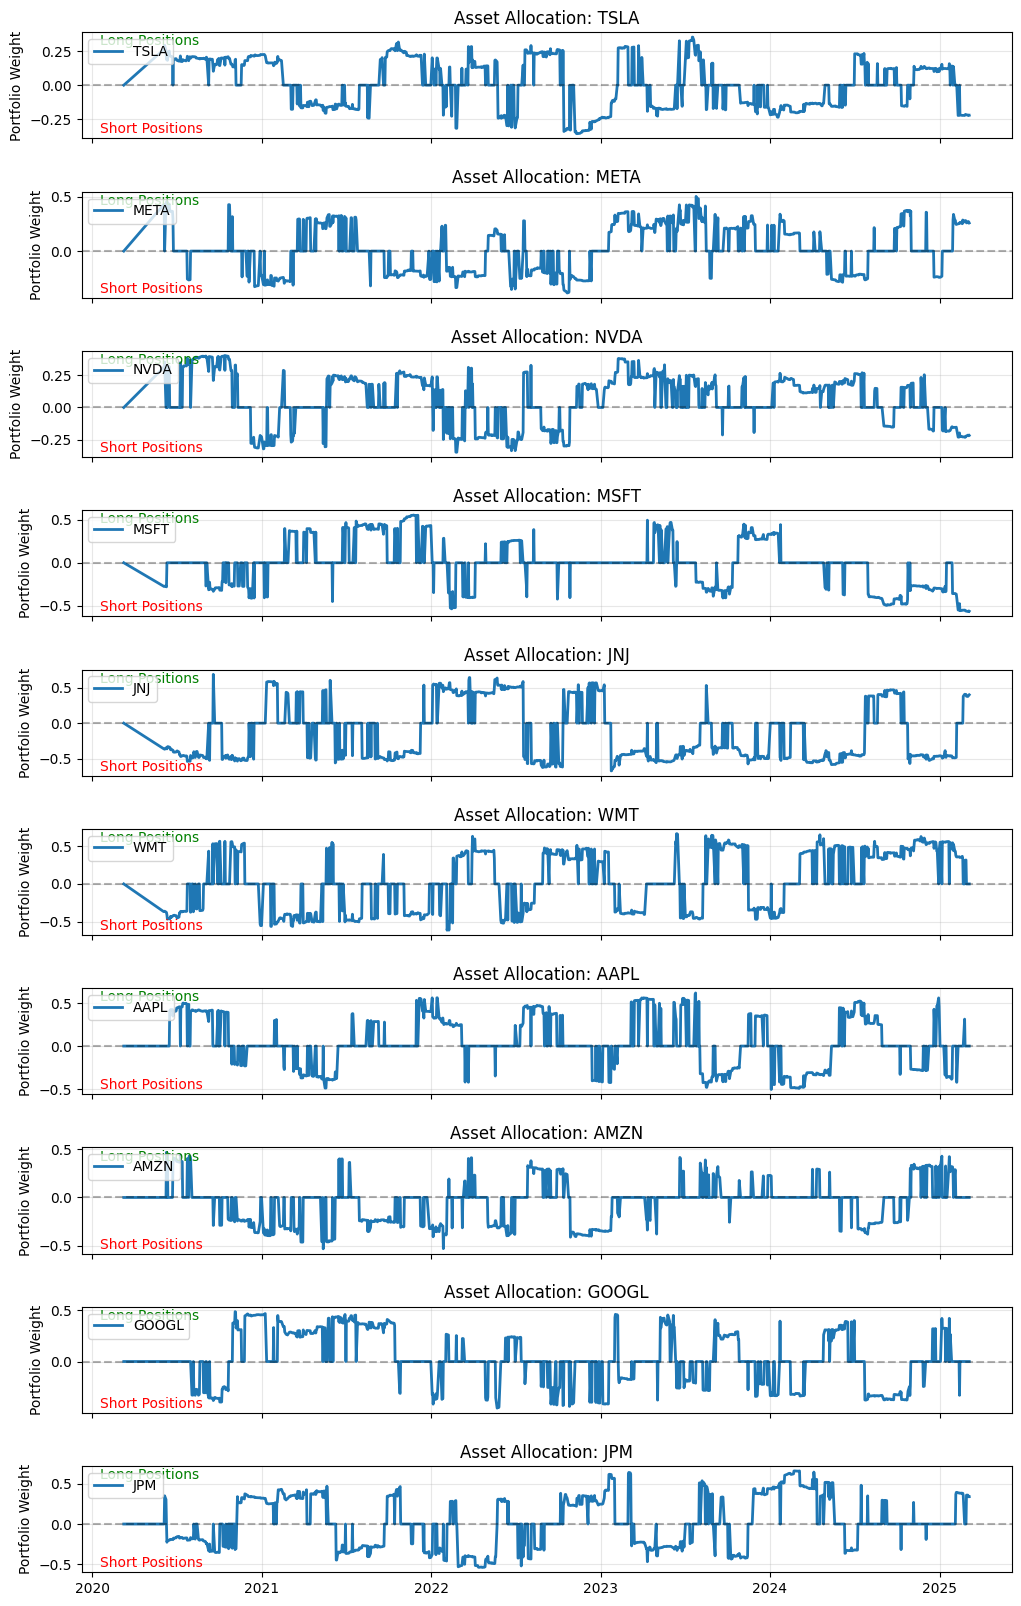

In [74]:
# Get the allocation DataFrame
allocation_df = get_asset_allocation_over_time(portfolio)

# View the first few rows
print(allocation_df.head())

# Plot the allocation over time
plot_asset_allocation(portfolio)